# Generating Datasets

A DeepLenstronomy Demo.

`deeplenstronomy` is a software package that let's you interact with the strong gravitational lensing simulation software `lenstronomy` in a streamlined framework. Let's take a look at how it works!

In [1]:
import deeplenstronomy.deeplenstronomy as dl

`deeplenstronomy` works by reading user-prepared configuration files. start by specifying the configuration file you will use to make the dataset.

In [2]:
config_file = 'data/demo.yaml'

The configuration file is a yaml-style file for specifying all the properties of your dataset. Here is what this file contains:

In [3]:
! cat data/demo.yaml

DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 100
        OUTDIR: MySimulationResults

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

IMAGE:
    PARAMETERS:
        exposure_time: 90
        numPix: 100
        pixel_scale: 0.263
        psf_type: 'GAUSSIAN'
        read_noise: 7
        ccd_gain: 6.083

SURVEY:
    PARAMETERS:
        BANDS: g,r,i,z,Y
        seeing: 0.9
        magnitude_zero_point: 30.0
        sky_brightness: 23.5
        num_exposures: 10

SPECIES:
    GALAXY_1:
        NAME: LENS
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 19.5
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        LIGHT_PROFILE_2:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 18.0
                center_x: 0.0
                center_y: 0

There's a lot of information in there. To learn about how configuration files for `deeplenstronomy` are structured, check out the [Creating `deeplenstronomy` Configuration Files](https://github.com/rmorgan10/deeplenstronomy/blob/master/Notebooks/ConfigFiles.md) documentation. 

## Simulating a Dataset

Let's put `deeplenstronomy` to work! 

In [4]:
dataset = dl.make_dataset(config_file)

That's it. You now have your dataset.

## Understanding the `make_dataset()` Function

All the information about the contents of the dataset is stored in the configuration file, but the `make_dataset()` function will tell `deeplenstronomy` what you want to do with your dataset.
Let's look at the function definition:

```python
def make_dataset(config, dataset=None, save_to_disk=False, store_in_memory=True,
                 verbose=False, store_sample=False, image_file_format='npy',
                 survey=None, return_planes=False, skip_image_generation=False,
                 solve_lens_equation=False):
    """
    Generate a dataset from a config file

    :param config: yaml file specifying dataset characteristics
                   OR
                   pre-parsed yaml file as a dictionary
    :param verbose: bool, if true, print status updates
    :param store_in_memory: bool, save images and metadata as attributes
    :param save_to_disk: bool, save images and metadata to disk
    :param store_sample: bool, save five images and metadata as attribute
    :param image_file_format: outfile format type (npy, h5)
    :param survey: str, a default astronomical survey to use
    :param return_planes: bool, if true, return the separate planes of simulated images
    :param skip_image_generation: bool, if true, skip image generation
    :param solve_lens_equation: bool, if true, calculate the source positions
    :return: dataset: instance of dataset class
    """
```

If all the default parameters work for you, then all you have to do is call `dataset = dl.make_dataset(config_file)` and you'll be good to go. If not, the parameters can be modified to product the desired behavior.

### `make_dataset()` Parameters:

- config

The filename of your configuration file as a string.

- verbose

If you would like brief status messages of the simulation to be printed as `make_dataset()` runs, you can set `verbose=True`.

- store_in_memory

By default, the simulated images and associated metadata will be stored in your computer's memory as attributes of the object returned by `make_dataset()`. If you would like to prevent this, typically motivated by just wanting to write the simulation products directly to output files, you can pass `store_in_memory=False`.

- save_to_disk

By default, the simulated images and associated metadata are not saved to output files. If you would like them to be saved, set `save_to_disk=True` and make sure to specify an out directory in your configuration file.

- store_sample

If you would like to take a peek at the simualted images and metadata to inspect them without storing the entire dataset in memory, you can set `store_sample=True`. This setting will store five images for each configuration in memory as attributes of the object returned by `make_dataset()`.

- image_file_format

When saving images to disk, you can choose the image file format. The currently supported options are (by default) `image_file_format='npy'` and `image_file_format='h5'`. 

- survey

`deeplenstronomy` has built in information about multiple large astronomical surveys. Currently, the options are `des`, `delve`, `lsst`, `ztf`, `euclid`, and `hst`. Specifying one of these will overwrite values of the `SURVEY` and `IMAGE` sections of your configuration file at runtime.

- return_planes

By default, `deeplenstronomy` will calculate light from lenses, sources, point sources, and noise separately before stacking them into one output image. If you would prefer to keep the lens, source, point source, and noise information separate for your analysis, you can pass `return_planes=True`. The image arrays in your dataset will gain an extra dimension of length 4 (one for each of these possible sources of light).

- skip_image_generation

If you would like to generate all the `lenstronomy` inputs specified in you configuration file but not generate images, for example to check that your distribtuions are working as expected, you can skip the image generation step while still outputing all the metadata by setting `skip_image_generation=True`.

- solve_lens_equation

If you would like to analyze the positions and numbers of individual images of the source galaxy in each of your dataset images you will need to solve the lens equation. To do this, set `solve_lens_equation=True` and this information will be calculated and sotred in the metadata. This calculation is skipped by default for performance considerations.


## Interacting with the Dataset

Now that we have a dataset, let's look at what was stored in the `dataset` variable.

The configuration labels you specified in the configuration file are stored here. The reasoning here is if you plan to do some sort of supervised classification, you will probably want to have the images labeled.

In [5]:
print(dataset.configurations)

['CONFIGURATION_1', 'CONFIGURATION_2', 'CONFIGURATION_3', 'CONFIGURATION_4']


The dataset name, size, and output directory are also stored as attributes of the dataset object.

In [6]:
print(dataset.name)
print(dataset.size)
print(dataset.outdir)

MyDeeplenstronomyDataset
100
MySimulationResults


There are a few other things that get stored automatically (that you can explore via `dir(dataset)`), but we'll shift our focus to the things we simulated.

The most interesting information is stored here in these attributes:

In [7]:
for item in [x for x in dir(dataset) if x[0:13] == 'CONFIGURATION']:
    print(item)

CONFIGURATION_1_images
CONFIGURATION_1_metadata
CONFIGURATION_2_images
CONFIGURATION_2_metadata
CONFIGURATION_3_images
CONFIGURATION_3_metadata
CONFIGURATION_4_images
CONFIGURATION_4_metadata


The `_images` attribute is a `numpy.ndarray` object and the `_metadata` attribute is a `pandas.DataFrame` object.

In [8]:
print(type(dataset.CONFIGURATION_1_images))
print(type(dataset.CONFIGURATION_1_metadata))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


### Images

Let's checkout some of the images in the `dataset.CONFIGURATION_1_images` attribute.

What's in this array?

In [9]:
print(dataset.CONFIGURATION_1_images.shape)

(25, 5, 100, 100)


The array dimensions are (image index, band, x_pixels, y_pixels). 

The number of images is the size of the dataset multiplied by the fraction of the dataset in CONFIGURATION_1, both of which you specify in the configuration file. The bands used is also specified in the configuration file. Finally, yup you guessed it, the image dimensions are also specified in the configuration file.

`deeplenstronomy` also has built-in vizualization functions that are demonstrated in more detail in the Visualization Notebook.

Let's look at the r-band of image index 2 in CONFIGURATION_1:

In [10]:
from deeplenstronomy.visualize import view_image

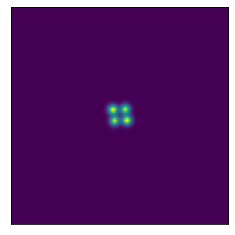

In [11]:
view_image(dataset.CONFIGURATION_1_images[2][1])

You can also look at all the bands for this image at once.

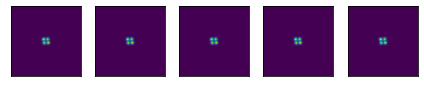

In [12]:
view_image(dataset.CONFIGURATION_1_images[2])

### Metadata

Once you have an image, you may want to consider the parameters that went into its generation to better understand what you made. To check that out, you can view the metadata saved by `deeplenstronomy`.

Let's look at the properties of the metadata.

In [13]:
dataset.CONFIGURATION_1_metadata.shape

(25, 415)

Wow. That's a lot of columns. The number of columns increases with the complexity of your configurations, since there is more information for `deeplenstronomy` to keep track of. The columns are also broken up my band, so doubling the number of bands will double the number of columns in the metadata.

Let's look at the column names to see what information we have.

In [14]:
for col in dataset.CONFIGURATION_1_metadata.columns:
    print(col)

OBJID-g
H0-g
Om0-g
exposure_time-g
numPix-g
pixel_scale-g
psf_type-g
read_noise-g
ccd_gain-g
seeing-g
magnitude_zero_point-g
sky_brightness-g
num_exposures-g
NUMBER_OF_NOISE_SOURCES-g
NOISE_SOURCE_1-NAME-g
NOISE_SOURCE_1-mean-g
CONFIGURATION_LABEL-g
CONFIGURATION_NAME-g
NUMBER_OF_PLANES-g
PLANE_1-NUMBER_OF_OBJECTS-g
PLANE_1-OBJECT_1-NAME-g
PLANE_2-NUMBER_OF_OBJECTS-g
PLANE_2-OBJECT_1-NAME-g
PLANE_2-OBJECT_2-NAME-g
PLANE_1-OBJECT_1-REDSHIFT-g
PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g
PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g
PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g
PLANE_1-OBJECT_1-HOST-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-NAME-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e2-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_2-NAME-g
PLANE_1-OBJECT_1-LIGHT

Every individual number used in the `lenstronomy` simulation is tracked.

As well, the row index in the metadata dataframe corresponds to the image index in the image array, so you can track which image has which properties. The dataframe contents can be accessed like this:

In [15]:
dataset.CONFIGURATION_1_metadata.iloc[0:5]

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,0,70,0.3,90,100,0.263,GAUSSIAN,7,6.083,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,70,0.3,90,100,0.263,GAUSSIAN,7,6.083,0.9,...,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7
2,2,70,0.3,90,100,0.263,GAUSSIAN,7,6.083,0.9,...,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7
3,3,70,0.3,90,100,0.263,GAUSSIAN,7,6.083,0.9,...,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7
4,4,70,0.3,90,100,0.263,GAUSSIAN,7,6.083,0.9,...,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7,0.2,0.7


## Saving Datasets

If you are working in interactive mode, you can straightforwardly save the images array and metadata dataframe in any file format you are comfortable with.

If you instead choose to set the `save_to_disk=True` option when making your dataset, let's look at what gets saved where.

In [16]:
saved_dataset = dl.make_dataset(config_file, save_to_disk=True)

Recall that the dataset object has the user-specified out directory as an attribute.

In [17]:
print(saved_dataset.outdir)

MySimulationResults


Let's look in that directory.

In [18]:
! ls MySimulationResults

CONFIGURATION_1_images.npy   CONFIGURATION_2_metadata.csv CONFIGURATION_4_images.npy
CONFIGURATION_1_metadata.csv CONFIGURATION_3_images.npy   CONFIGURATION_4_metadata.csv
CONFIGURATION_2_images.npy   CONFIGURATION_3_metadata.csv lightcurves


The image arrays have been stored as numpy files. They can be loaded by doing
```python
images = numpy.load('MySimulationResults/CONFIGURATION_1_images.npy')
```

The metadata dataframes have been written to csv files. They can be loaded by doing
```python
metadata = pandas.read_csv('MySimulationResults/CONFIGURATION_1_metadata.csv')
```

Future versions of `deeplenstronomy` will include file format flexibility and built in dataset loading funcitons.

## The End

That's pretty much it to generating datasets with `deeplenstronomy`! Feel free to contact me with any suggestions or bugs.